In [ ]:
from tqdm.auto import tqdm, trange
from tabulate import tabulate
import plotly.graph_objects as go
from IPython.display import clear_output
from plotly.subplots import make_subplots
import time
import os
from copy import deepcopy

import json
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


import dhg
from dhg import Graph, Hypergraph
from dhg.data import Cooking200, News20, CocitationCiteseer, CocitationCora, HouseCommittees
from dhg.models import GCN, HGNN, HGNNP, HNHN, UniGCN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
from dhg.utils import split_by_ratio

from typing import Optional, Dict, Any, List

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval
from itertools import combinations

In [132]:
set_seed(42)

In [133]:
def get_top_k_densest_subgraphs(hg: Hypergraph, k: int = 3, max_minutes=2) -> list:
    """Faster implementation with timeout and early stopping"""
    import time
    start_time = time.time()
    
    nodes = set(range(hg.num_v))
    subgraphs = []
    edge_set = [set(e) for e in hg.e[0]]  # Precompute for faster checks
    
    for _ in range(k):
        if time.time() - start_time > max_minutes * 60:
            print(f"Timeout after {max_minutes} minutes, returning {len(subgraphs)} subgraphs")
            break
            
        if len(nodes) < 3:
            break
            
        current_nodes = set(nodes)
        best_subset = None
        best_density = -1
        
        # Precompute degrees once per iteration
        degrees = {v: sum(v in e for e in edge_set) for v in current_nodes}
        
        while len(current_nodes) >= 3:
            # Check timeout every 100 iterations
            if len(current_nodes) % 100 == 0 and time.time() - start_time > max_minutes * 60:
                break
                
            # Fast edge counting using precomputed edge_set
            edge_count = sum(1 for e in edge_set if e.issubset(current_nodes))
            density = edge_count / len(current_nodes)
            
            if density > best_density:
                best_density = density
                best_subset = set(current_nodes)
            
            # Remove node with lowest degree
            node_to_remove = min(degrees.keys(), key=lambda x: degrees[x])
            current_nodes.remove(node_to_remove)
            del degrees[node_to_remove]  # Maintain degree dict
            
        if best_subset and best_density > 0:
            subgraphs.append((best_subset, best_density))
            nodes -= best_subset
    
    return subgraphs

In [134]:
def preprocess_hypergraph_with_topk(hg: Hypergraph, k: int = 3, timeout_minutes: int = 2) -> Hypergraph:
    """Optimized Top-k preprocessing with timeout and fallback"""
    try:
        print(f"Starting Top-{k} preprocessing (timeout: {timeout_minutes}min)...")
        start_time = time.time()
        
        # Edge pre-processing for faster checks
        edge_sets = [set(e) for e in hg.e[0]]
        node_degrees = {v: sum(v in e for e in edge_sets) for v in range(hg.num_v)}
        
        # Find top-k subgraphs
        subgraphs = []
        remaining_nodes = set(range(hg.num_v))
        
        for _ in range(k):
            if time.time() - start_time > timeout_minutes * 60:
                print(f"Timeout after {timeout_minutes} minutes")
                break
                
            if len(remaining_nodes) < 3:
                break
                
            current_nodes = set(remaining_nodes)
            best_subset = None
            best_density = -1
            
            while len(current_nodes) >= 3:
                # Check timeout every 100 nodes
                if len(current_nodes) % 100 == 0 and time.time() - start_time > timeout_minutes * 60:
                    break
                    
                # Fast edge counting
                edge_count = sum(1 for e in edge_sets if e.issubset(current_nodes))
                density = edge_count / len(current_nodes)
                
                if density > best_density:
                    best_density = density
                    best_subset = set(current_nodes)
                
                # Remove lowest degree node
                node_to_remove = min(current_nodes, key=lambda x: node_degrees[x])
                current_nodes.remove(node_to_remove)
            
            if best_subset and best_density > 0:
                subgraphs.append((best_subset, best_density))
                remaining_nodes -= best_subset
        
        # Create new hypergraph
        if subgraphs:
            important_nodes = set().union(*[s[0] for s in subgraphs])
            new_edges = [e for e in hg.e[0] if set(e).issubset(important_nodes)]
            
            reduction_pct = 100 * (1 - len(new_edges)/len(hg.e[0]))
            print(f"Top-k kept {len(new_edges)}/{len(hg.e[0])} edges "
                  f"({reduction_pct:.1f}% reduction)")
            return Hypergraph(hg.num_v, new_edges)
            
        raise RuntimeError("No valid subgraphs found")
        
    except Exception as e:
        print(f"Top-k preprocessing failed ({str(e)}), using original hypergraph")
        return hg
    
def infer(net, X, A, lbls, idx, evaluator, test=False):
    """Returns either a float (accuracy) or full metrics dict"""
    net.eval()
    with torch.no_grad():
        outs = net(X, A)
        outs, lbls = outs[idx], lbls[idx]
        if test:
            return evaluator.test(lbls, outs)  # Returns dict
        return evaluator.validate(lbls, outs)  # Returns float


def train(net, X, A, lbls, train_idx, optimizer, epoch, max_batch_time=30.0):
    """Training function with safety checks"""
    net.train()
    st = time.time()
    
    try:
        optimizer.zero_grad()
        outs = net(X, A)
        outs, lbls = outs[train_idx], lbls[train_idx]
        
        # Safety checks
        if torch.isnan(outs).any() or torch.isinf(outs).any():
            raise RuntimeError("NaN/Inf in outputs")
        if time.time() - st > max_batch_time:
            raise RuntimeError(f"Forward pass > {max_batch_time}s")
            
        loss = F.cross_entropy(outs, lbls)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()
        
        elapsed = time.time() - st
        print(f"Epoch {epoch}: Loss {loss.item():.4f} | Time {elapsed:.2f}s")
        return loss.item()
        
    except Exception as e:
        print(f"Training error at epoch {epoch}: {str(e)}")
        raise

In [135]:
def run_experiment(dataset_name, model_class, use_topk=False, k=3, epochs=200):
    """Main experiment function"""
    # Initialize evaluator
    evaluator = Evaluator(["accuracy", "f1_score"])
    
    # Load dataset
    data = globals()[dataset_name]('./datasets/dhg_datasets')


     # Debug: Print dataset structure
    print(f"\nDataset structure inspection for {dataset_name}:")
    print("Available keys:", data._content.keys())
    if hasattr(data, "e"):
        print("Hypergraph edges (data.e[0]):", len(data.e[0]), "hyperedges")
    if "edge_list" in data._content:
        print("edge_list exists with length:", len(data["edge_list"]))
    
    # Extract hyperedges - handle all DHG hypergraph dataset formats
    if hasattr(data, "e") and len(data.e) > 0:
        edge_list = data.e[0]  # Most common case
    elif "edge_list" in data._content:
        edge_list = data["edge_list"]
    else:
        # Last resort: try to find edges in unexpected locations
        for key in data._content:
            if isinstance(data._content[key], list) and len(data._content[key]) > 0:
                if isinstance(data._content[key][0], (list, set)):
                    edge_list = data._content[key]
                    break
        else:
            raise ValueError(f"Could not find hyperedges in dataset {dataset_name}. Available keys: {list(data._content.keys())}")
    
    print(f"Using {len(edge_list)} hyperedges from dataset")
    
    # Split data
    if not 'train_mask' in data.content:
        train_mask, test_mask, val_mask = split_by_ratio(
            data["num_vertices"], data["labels"], 0.6, 0.2, 0.2)
        data._content.update({
            "train_mask": train_mask,
            "test_mask": test_mask,
            "val_mask": val_mask
        })
    
    # Prepare data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    
    # Top-k preprocessing
    if use_topk:
        G = preprocess_hypergraph_with_topk(G, k)
    
    # Initialize model
    model_map = {
        "HGNN": HGNN,
        "HGNNP": HGNNP, 
        "UniGCN": UniGCN
    }
    net = model_map[model_class](X.shape[1], 16, data["num_classes"], use_bn=True)
    
    # Training setup
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)
    X, lbl, G = X.to(device), lbl.to(device), G.to(device)
    net = net.to(device)
    
    # Training loop
    best_state = None
    best_val_acc = -1.0  # Track just the accuracy value
    train_losses = []
    val_accuracies = []  # Track validation accuracies as floats
    
    for epoch in range(epochs):
        # Training
        loss = train(net, X, G, lbl, data["train_mask"], optimizer, epoch)
        train_losses.append(loss)
        
        # Validation (returns float)
        val_acc = infer(net, X, G, lbl, data["val_mask"], evaluator)
        val_accuracies.append(val_acc)
        
        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = deepcopy(net.state_dict())
            print(f"Epoch {epoch}: New best val accuracy {val_acc:.4f}")
    
    # Testing (returns dict)
    net.load_state_dict(best_state)
    test_metrics = infer(net, X, G, lbl, data["test_mask"], evaluator, test=True)

    
    print("\n=== Final Results ===")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print("Test Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")

    

    accuracy = test_metrics.get("accuracy", 0)
    f1_score = test_metrics.get("f1_score", 0)
    
    return {
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "test_accuracy": accuracy,
        "f1_score": f1_score,  # Add F1 score
        "best_val": best_val_acc,
        "best_epoch": np.argmax(val_accuracies) if val_accuracies else 0
    }

In [136]:
# Experiment configuration
datasets = ["Cooking200", "CocitationCiteseer", "HouseCommittees"]
models = ["HGNN", "HGNNP", "UniGCN"]
use_topk_options = [False, True]
k = 3
epochs = 200

In [137]:
# Run experiments
results = []

for dataset in datasets:
    for model in models:
        for use_topk in use_topk_options:
            print(f"\n{'='*50}")
            print(f"Running experiment: Dataset={dataset}, Model={model}, Top-k={use_topk}")
            print(f"{'='*50}")
            
            exp_result = run_experiment(
                dataset_name=dataset,
                model_class=model,
                use_topk=use_topk,
                k=k,
                epochs=epochs
            )
            
            results.append({
                "dataset": dataset,
                "model": model,
                "topk": use_topk,
                "test_accuracy": exp_result["test_accuracy"],
                "f1_score": exp_result["f1_score"],  # This line was missing
                "best_val_accuracy": exp_result["best_val"],
                "best_epoch": exp_result["best_epoch"],
                "train_losses": exp_result["train_losses"],
                "val_accuracies": exp_result["val_accuracies"]
})


Running experiment: Dataset=Cooking200, Model=HGNN, Top-k=False

Dataset structure inspection for Cooking200:
Available keys: dict_keys(['num_classes', 'num_vertices', 'num_edges', 'edge_list', 'labels', 'train_mask', 'val_mask', 'test_mask'])
edge_list exists with length: 2755
Using 2755 hyperedges from dataset
Epoch 0: Loss 3.0093 | Time 1.28s
Epoch 0: New best val accuracy 0.0500
Epoch 1: Loss 2.8719 | Time 0.78s
Epoch 2: Loss 2.5815 | Time 0.77s
Epoch 3: Loss 2.4233 | Time 0.76s
Epoch 4: Loss 2.3051 | Time 0.75s
Epoch 5: Loss 2.2005 | Time 0.76s
Epoch 6: Loss 2.0954 | Time 0.79s
Epoch 7: Loss 2.0234 | Time 0.77s
Epoch 8: Loss 1.9134 | Time 0.77s
Epoch 8: New best val accuracy 0.0950
Epoch 9: Loss 1.8486 | Time 0.82s
Epoch 10: Loss 1.7635 | Time 0.77s
Epoch 11: Loss 1.6741 | Time 0.77s
Epoch 12: Loss 1.6036 | Time 0.76s
Epoch 13: Loss 1.5131 | Time 0.77s
Epoch 14: Loss 1.4575 | Time 0.80s
Epoch 15: Loss 1.3670 | Time 0.78s
Epoch 16: Loss 1.2855 | Time 0.76s
Epoch 17: Loss 1.2254 | 

In [138]:
# Visualization and Results Analysis
def plot_training_curves(results):
    for dataset in datasets:
        plt.figure(figsize=(15, 8))
        plt.suptitle(f"Training Curves - {dataset}", fontsize=16)
        
        for i, model in enumerate(models, 1):
            plt.subplot(2, 3, i)
            for use_topk in use_topk_options:
                # Find matching result
                res = next(r for r in results 
                          if r["dataset"] == dataset 
                          and r["model"] == model 
                          and r["topk"] == use_topk)
                
                label = f"{model} {'(Top-k)' if use_topk else ''}"
                plt.plot(res["train_losses"], label=f"{label} - Train Loss", alpha=0.7)
                plt.plot(res["val_accuracies"], label=f"{label} - Val Acc", linestyle='--', alpha=0.7)
            
            plt.xlabel("Epoch")
            plt.ylabel("Value")
            plt.title(model)
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

def create_results_table(results):
     data = []
     for res in results:
        # Safely get all values with defaults
        row = [
            res["dataset"],
            res["model"],
            "Yes" if res.get("topk", False) else "No",
            f"{res.get('best_val_accuracy', 0):.4f}",
            f"{res.get('test_accuracy', 0):.4f}",
            f"{res.get('f1_score', 0):.4f}",  # Will show 0 if missing
            res.get("best_epoch", 0)
        ]
        data.append(row)
    
     df = pd.DataFrame(data, columns=[
        "Dataset", "Model", "Top-k", 
        "Best Val Accuracy", 
        "Test Accuracy",
        "F1 Score",
        "Best Epoch"
    ])
    
     display(df.style
           .background_gradient(cmap='Blues', subset=["Best Val Accuracy", "Test Accuracy", "F1 Score"])
           .set_caption("Experiment Results"))
     
     # Export to CSV
     csv_filename = "hypergraph_results.csv"
     df.to_csv(csv_filename, index=False)
     print(f"\nResults saved to {csv_filename}")
    
    
     return df

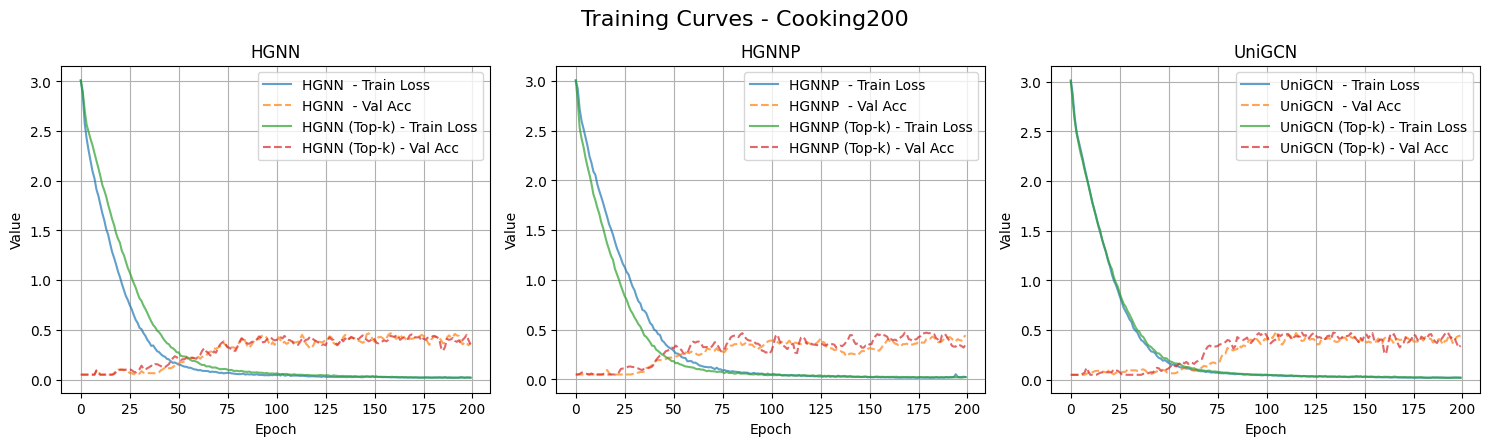

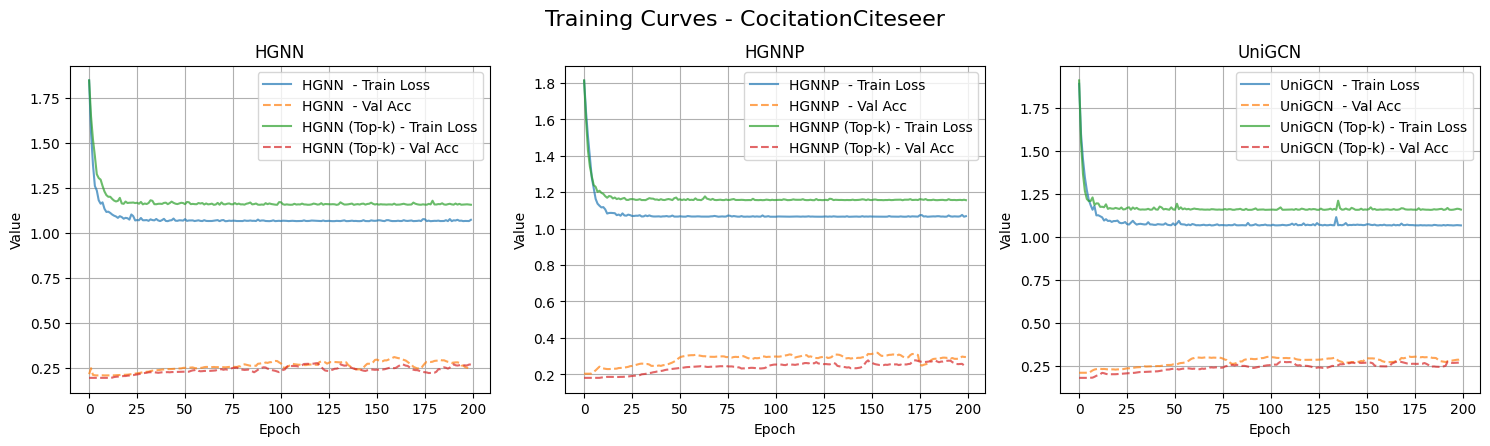

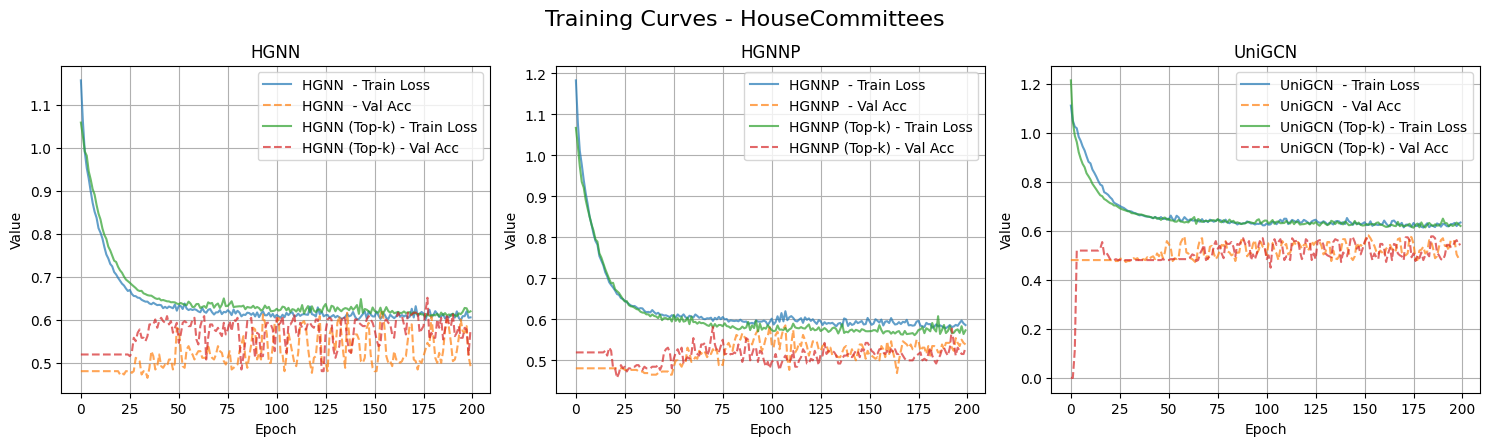

,Dataset,Model,Top-k,Best Val Accuracy,Test Accuracy,F1 Score,Best Epoch
0,Cooking200,HGNN,No,0.4650,0.3961,0.3371,147
1,Cooking200,HGNN,Yes,0.4550,0.4538,0.3780,169
2,Cooking200,HGNNP,No,0.4450,0.4755,0.3693,199
3,Cooking200,HGNNP,Yes,0.4700,0.4705,0.3788,168
4,Cooking200,UniGCN,No,0.4850,0.4271,0.3459,105
5,Cooking200,UniGCN,Yes,0.4800,0.4471,0.3559,192
6,CocitationCiteseer,HGNN,No,0.3091,0.3091,0.2404,159
7,CocitationCiteseer,HGNN,Yes,0.2754,0.2754,0.1885,119
8,CocitationCiteseer,HGNNP,No,0.3182,0.3182,0.2497,153
9,CocitationCiteseer,HGNNP,Yes,0.2769,0.2769,0.1992,172



Results saved to hypergraph_results.csv


In [ ]:
# Generate visualizations
plot_training_curves(results)

# Generate results table
results_df = create_results_table(results)

# Save results for future reference
results_df.to_csv(r'.\datasets\dhg_results', index=False)

In [8]:
df = pd.read_csv(r'.\datasets\dhg_results.csv')

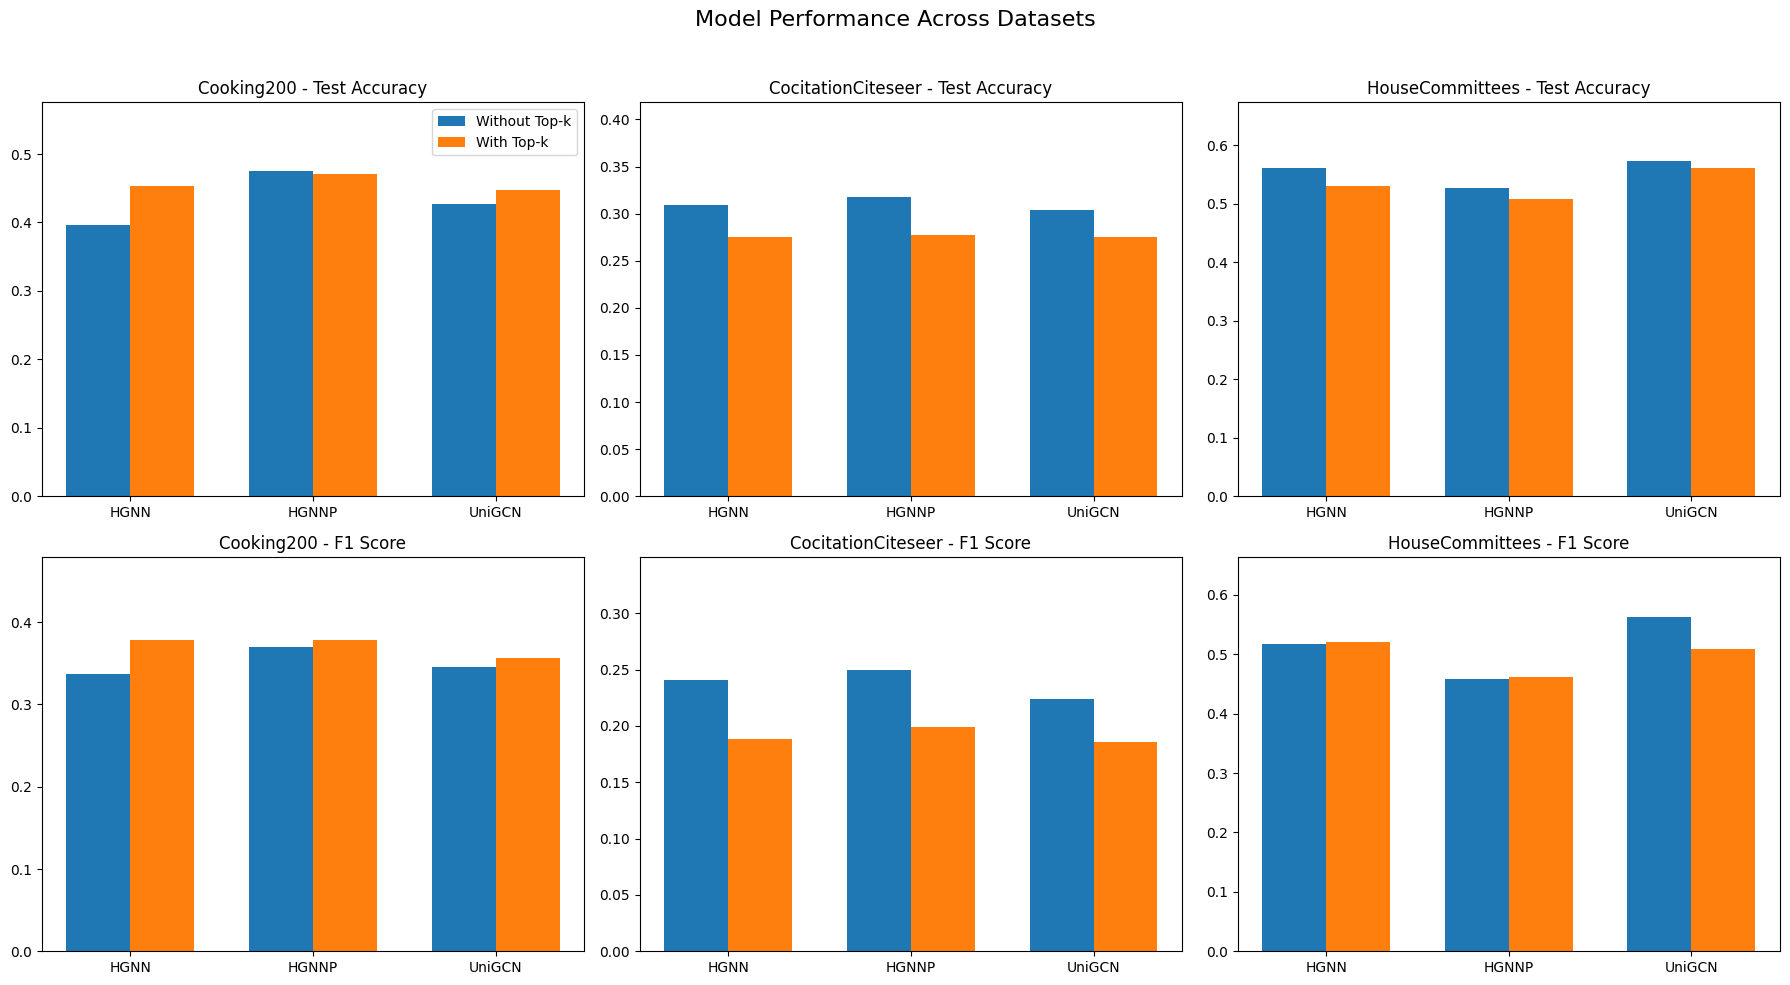

In [9]:
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3)

datasets = df['Dataset'].unique()
metrics = ['Test Accuracy', 'F1 Score']


for row, metric in enumerate(metrics):
    for col, dataset in enumerate(datasets):
        ax = axes[row, col]
        subset = df[df['Dataset'] == dataset]
        models = ['HGNN', 'HGNNP', 'UniGCN']

        values_no = [subset[(subset['Model'] == model) & (subset['Top-k'] == 'No')][metric].values[0] for model in models]
        values_yes = [subset[(subset['Model'] == model) & (subset['Top-k'] == 'Yes')][metric].values[0] for model in models]

        x = range(len(models))
        bar_width = 0.35

        ax.bar([i - bar_width/2 for i in x], values_no, width=bar_width, label='Without Top-k')
        ax.bar([i + bar_width/2 for i in x], values_yes, width=bar_width, label='With Top-k')

        ax.set_title(f'{dataset} - {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.set_ylim(0, max(values_no + values_yes) + 0.1)
        if row == 0 and col == 0:
            ax.legend()

plt.suptitle('Model Performance Across Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [10]:
grouped = df.groupby(["Dataset", "Model"])

result = []
for (dataset, model), group in grouped:
    without_topk = group[group["Top-k"] == "No"].iloc[0]
    with_topk = group[group["Top-k"] == "Yes"].iloc[0]
    
    result.append({
        "Dataset": dataset,
        "Model": model,
        "Test Accuracy without Top-k": without_topk["Test Accuracy"],
        "Test Accuracy with Top-k": with_topk["Test Accuracy"],
        "F1 Score without Top-k": without_topk["F1 Score"],
        "F1 Score with Top-k": with_topk["F1 Score"]
    })


result_df = pd.DataFrame(result)


result_df = result_df[[
    "Dataset", "Model", 
    "Test Accuracy without Top-k", "Test Accuracy with Top-k",
    "F1 Score without Top-k", "F1 Score with Top-k"
]]

result_df['Acc_diff'] = (result_df['Test Accuracy with Top-k'] - result_df['Test Accuracy without Top-k']) * 100
result_df['F1_diff'] = (result_df['F1 Score with Top-k'] - result_df['F1 Score without Top-k']) * 100

result_df

,Dataset,Model,Test Accuracy without Top-k,Test Accuracy with Top-k,F1 Score without Top-k,F1 Score with Top-k,Acc_diff,F1_diff
0,CocitationCiteseer,HGNN,0.3091,0.2754,0.2404,0.1885,-3.37,-5.19
1,CocitationCiteseer,HGNNP,0.3182,0.2769,0.2497,0.1992,-4.13,-5.05
2,CocitationCiteseer,UniGCN,0.3043,0.2757,0.2236,0.1856,-2.86,-3.80
3,Cooking200,HGNN,0.3961,0.4538,0.3371,0.3780,5.77,4.09
4,Cooking200,HGNNP,0.4755,0.4705,0.3693,0.3788,-0.50,0.95
5,Cooking200,UniGCN,0.4271,0.4471,0.3459,0.3559,2.00,1.00
6,HouseCommittees,HGNN,0.5620,0.5310,0.5167,0.5200,-3.10,0.33
7,HouseCommittees,HGNNP,0.5271,0.5078,0.4582,0.4623,-1.93,0.41
8,HouseCommittees,UniGCN,0.5736,0.5620,0.5631,0.5087,-1.16,-5.44


In [11]:
result_df = result_df[
    ['Dataset', 'Model', 
     'Test Accuracy without Top-k', 'Test Accuracy with Top-k', 'Acc_diff', 
     'F1 Score without Top-k', 'F1 Score with Top-k',  'F1_diff']]

result_df = result_df.rename(columns={
    'Test Accuracy without Top-k': 'Base Acc',
    'Test Accuracy with Top-k': 'Top-k Acc',
    'Acc_diff': 'Acc Diff',
    'F1 Score without Top-k': 'Base F1',
    'F1 Score with Top-k': 'Top-k F1'
})

result_df

,Dataset,Model,Base Acc,Top-k Acc,Acc Diff,Base F1,Top-k F1,F1_diff
0,CocitationCiteseer,HGNN,0.3091,0.2754,-3.37,0.2404,0.1885,-5.19
1,CocitationCiteseer,HGNNP,0.3182,0.2769,-4.13,0.2497,0.1992,-5.05
2,CocitationCiteseer,UniGCN,0.3043,0.2757,-2.86,0.2236,0.1856,-3.80
3,Cooking200,HGNN,0.3961,0.4538,5.77,0.3371,0.3780,4.09
4,Cooking200,HGNNP,0.4755,0.4705,-0.50,0.3693,0.3788,0.95
5,Cooking200,UniGCN,0.4271,0.4471,2.00,0.3459,0.3559,1.00
6,HouseCommittees,HGNN,0.5620,0.5310,-3.10,0.5167,0.5200,0.33
7,HouseCommittees,HGNNP,0.5271,0.5078,-1.93,0.4582,0.4623,0.41
8,HouseCommittees,UniGCN,0.5736,0.5620,-1.16,0.5631,0.5087,-5.44
